In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/metricobjects/master/init.py
import init; init.init(force_download=False);

In [1]:
try:
    import einsteinpy
except ModuleNotFoundError:
    !pip install einsteinpy
import sys
if 'google.colab' in sys.modules:
    !pip install --upgrade sympy
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    import sympy as sy
    sy.init_printing(use_latex='matplotlib')

else:
    import sympy as sy
    sy.init_printing(use_latex=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols, RiemannCurvatureTensor, RicciTensor
import itertools



# The transformation induced by a perceptron

- $dim\_u$: the number of input neurons
- $dim\_x$: the number of ouput neurons

### if $dim\_u<dim\_x$ we have an embedding of a flat manifold in a larger, also flat, ambient space
### if $dim\_u>dim\_x$ we have a projection of a flat manifold in a smaller, also flat, projection space


- **input**: $\mathbf{u} = u^\alpha \in \mathbb{R}^{dim\_u}$ (indices as greek letters)
- **output**: $\mathbf{x} = x^i \in \mathbb{R}^{dim\_x}$ (indices as latin letters)
- **weights**: $\mathbf{W} = W^i_\alpha \in \mathbb{R}^{dim\_x\;\times\; dim\_u}$
- **biases**: $\mathbf{b} = b^i \in \mathbb{R}^{dim\_x}$
- **activation**: $\text{a}: \mathbb{R} \rightarrow \mathbb{R}$ (or vectorized component-wise)


## Metric objects

$$\begin{align*}
\text{The transformation function}\;\;\;: \;\;\;&x^i&= \;\;\;&x^i(u^\alpha, u^\beta,...)&s^i= \;\;\;& W^i_\gamma u^\gamma + b^i\\
&&&&x^i= \;\;\;& \text{a}(s^i)\\
\text{The Jacobian}\;\;\;: \;\;\;&\mathbf{J} \;= \; J^i_\alpha &= \;\;\;&\frac{\partial x^i}{\partial u^\alpha}&= \;\;\; &\dot{\text{a}}(s^i) W^i_\alpha \\
\text{The Hessian}\;\;\;: \;\;\;&\mathbf{H} \;= \; H^i_{\alpha\beta} &= \;\;\;&\frac{\partial x^i}{\partial u^\alpha\partial u^\beta} &= \;\;\;&\ddot{\text{a}}(s^i) W^i_\alpha W^i_\beta \\
\text{The Metric Tensor}\;\;\;: \;\;\;&g_{\alpha\beta} &= \;\;\;& \mathbf{J}^T\mathbf{J} = \sum_{k=0}^2 J^k_\alpha J^k_\beta&= \;\;\; &\sum_{k=0}^2 \dot{\text{a}}(s^k)^2 W^k_\alpha W^k_\beta \\
\text{The Derivatives of the Metric Tensor}\;\;\;: \;\;\;&g_{\alpha\beta},\gamma &= \;\;\;&\frac{\partial g_{\alpha\beta}}{\partial u^\gamma}  &= \;\;\;  &\sum_{k=0}^2 2\dot{\text{a}}(s^k)\ddot{\text{a}}(s^k) W^k_\alpha W^k_\beta W^k_\gamma\\
\text{The Christoffel Symbols}\;\;\;: \;\;\;&\Gamma^\beta_{\mu\nu} &= \;\;\;& \frac{1}{2}g^{\beta\alpha}\Big(g_{\alpha\mu,\nu} + g_{\alpha\nu,\mu} - g_{\mu\nu,\alpha}  \Big)\\
\text{The Derivatives of the Christoffel Symbols}\;\;\;: \;\;\;&\Gamma^\beta_{\mu\nu,\gamma}  &= \;\;\;&\frac{\partial \Gamma^\beta_{\mu\nu} }{\partial u^\gamma}\\
\text{The Riemman Curvature Tensor}^{(*)}\;\;\;: \;\;\;&R^i_{jkm} &= \;\;\;&\Gamma^i_{jm,k} - \Gamma^i_{jk,m} + \Gamma^i_{rk}\Gamma^r_{jm} - \Gamma^i_{rm}\Gamma^r_{jk}\\
\text{The Ricci Tensor}^{(*)}\;\;\;: \;\;\;&R_{jm} &= \;\;\;& R^i_{jim}\\
\text{The Ricci Scalar}^{(*)}\;\;\;: \;\;\;&R &= \;\;\;& g^{jm}R_{jm} \\
\end{align*}$$

$$_\text{(*) keeping standard notation with latin indices but should use greek indices as it refers to the output manifold}$$


https://digitalcommons.latech.edu/cgi/viewcontent.cgi?article=1008&context=mathematics-senior-capstone-papers

https://math.stackexchange.com/questions/1809324/visual-explanation-of-the-indices-of-the-riemann-curvature-tensor

In [3]:
dim_u = 2
dim_x = 3

W = sy.MatrixSymbol("W", dim_x,dim_u)
u = sy.MatrixSymbol("u", dim_u,1)
linear  = lambda s: s
sqr     = lambda s: s**2
sigmoid = lambda s: 1/(1+sy.exp(-s))
a = sigmoid
s = sy.Matrix([i for i in W*u])
x = sy.Matrix([a(i) for i in s])
W, u, s, x

⎛                           ⎡           1           ⎤⎞
⎜                           ⎢───────────────────────⎥⎟
⎜                           ⎢ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎥⎟
⎜                           ⎢ℯ                   + 1⎥⎟
⎜                           ⎢                       ⎥⎟
⎜      ⎡W₀₀⋅u₀₀ + W₀₁⋅u₁₀⎤  ⎢           1           ⎥⎟
⎜      ⎢                 ⎥  ⎢───────────────────────⎥⎟
⎜W, u, ⎢W₁₀⋅u₀₀ + W₁₁⋅u₁₀⎥, ⎢ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎥⎟
⎜      ⎢                 ⎥  ⎢ℯ                   + 1⎥⎟
⎜      ⎣W₂₀⋅u₀₀ + W₂₁⋅u₁₀⎦  ⎢                       ⎥⎟
⎜                           ⎢           1           ⎥⎟
⎜                           ⎢───────────────────────⎥⎟
⎜                           ⎢ -W₂₀⋅u₀₀ - W₂₁⋅u₁₀    ⎥⎟
⎝                           ⎣ℯ                   + 1⎦⎠

##  the jacobian of the transformation

$$\mathbf{J} = J^i_\alpha = \frac{\partial x^i}{\partial u^\alpha}$$

in this case

$$\begin{align*}
\frac{\partial x^i}{\partial u^\alpha} =&  \frac{\partial \text{a}(s^i)}{\partial u^\alpha} \\
 =& \frac{\partial \text{a}(s^i)}{\partial s^i} \frac{\partial s^i}{\partial u^\alpha}\\
 =& \dot{\text{a}}(s^i) W^i_\alpha\\
\end{align*}$$

denoting $\frac{\partial \text{a}(s^i)}{\partial s^i}=\dot{\text{a}}(s^i)$


$$\mathbf{J} = J^i_\alpha = \dot{\text{a}}(s^i) W^i_\alpha$$

and observing that $ \frac{\partial s^i}{\partial u^\alpha} =  \frac{\partial}{\partial u^\alpha}(W^i_\gamma u^\gamma + b^i)=W^i_\alpha$

In [4]:
J = sy.Matrix([[j.diff(i) for  i in u] for j in x])
J

⎡  -W₀₀⋅u₀₀ - W₀₁⋅u₁₀          -W₀₀⋅u₀₀ - W₀₁⋅u₁₀      ⎤
⎢ ℯ                  ⋅W₀₀     ℯ                  ⋅W₀₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2                           2⎥
⎢⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞   ⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞ ⎥
⎢⎝ℯ                   + 1⎠   ⎝ℯ                   + 1⎠ ⎥
⎢                                                      ⎥
⎢  -W₁₀⋅u₀₀ - W₁₁⋅u₁₀          -W₁₀⋅u₀₀ - W₁₁⋅u₁₀      ⎥
⎢ ℯ                  ⋅W₁₀     ℯ                  ⋅W₁₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2                           2⎥
⎢⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞   ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞ ⎥
⎢⎝ℯ                   + 1⎠   ⎝ℯ                   + 1⎠ ⎥
⎢                                                      ⎥
⎢  -W₂₀⋅u₀₀ - W₂₁⋅u₁₀          -W₂₀⋅u₀₀ - W₂₁⋅u₁₀      ⎥
⎢ ℯ                  ⋅W₂₀     ℯ                  ⋅W₂₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2    

just as exercise, we can do this by hand if we use the sigmoid. Observe its differential

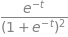

In [5]:
t = sy.symbols('t')
sigmoid(t).diff(t)

substituting $t$ with $s^i$ to obtain $\dot{\text{a}}(s^i)$

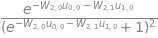

In [6]:
sigmoid(t).diff(t).subs({t: s[dim_x-1]})

to we can build the Jacobian by hand for the sigmoid

In [7]:
J_hand = sy.Matrix([[sigmoid(t).diff(t).subs({t: s[i]})*W[i,alpha] for i in range(dim_x)] for alpha in range(dim_u)]).T
J_hand

⎡  -W₀₀⋅u₀₀ - W₀₁⋅u₁₀          -W₀₀⋅u₀₀ - W₀₁⋅u₁₀      ⎤
⎢ ℯ                  ⋅W₀₀     ℯ                  ⋅W₀₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2                           2⎥
⎢⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞   ⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞ ⎥
⎢⎝ℯ                   + 1⎠   ⎝ℯ                   + 1⎠ ⎥
⎢                                                      ⎥
⎢  -W₁₀⋅u₀₀ - W₁₁⋅u₁₀          -W₁₀⋅u₀₀ - W₁₁⋅u₁₀      ⎥
⎢ ℯ                  ⋅W₁₀     ℯ                  ⋅W₁₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2                           2⎥
⎢⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞   ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞ ⎥
⎢⎝ℯ                   + 1⎠   ⎝ℯ                   + 1⎠ ⎥
⎢                                                      ⎥
⎢  -W₂₀⋅u₀₀ - W₂₁⋅u₁₀          -W₂₀⋅u₀₀ - W₂₁⋅u₁₀      ⎥
⎢ ℯ                  ⋅W₂₀     ℯ                  ⋅W₂₁  ⎥
⎢──────────────────────────  ──────────────────────────⎥
⎢                         2    

In [8]:
J==J_hand

True

get numerical evaluations

In [9]:
def sy_eval(expr, W, u, nW, nu):
    return np.r_[expr.subs({W[i,alpha]: nW[i, alpha] for i,alpha in itertools.product(range(0,dim_x), range(0,dim_u))})\
                     .subs({u[alpha,0]: nu[alpha,0] for alpha in range(0,dim_u)})].astype(float)


In [10]:
sy_eval(x, W, u, nW=np.random.normal(size=W.shape), nu=np.random.normal(size=u.shape))

array([[0.19254481],
       [0.2680553 ],
       [0.86977336]])

In [11]:
sy_eval(J, W, u, nW=np.random.normal(size=W.shape), nu=np.random.normal(size=u.shape))

array([[-0.04185382, -0.13996193],
       [ 0.15571656,  0.05539929],
       [-0.06997518, -0.18963061]])


### now in TensorFlow

In [12]:
tW = tf.Variable(np.random.normal(size=(dim_x,dim_u)), name="W")
tu = tf.Variable(np.random.normal(size=(dim_u,1)))
tb  = tf.Variable(np.zeros((dim_x,1)))
tW, tu

(<tf.Variable 'W:0' shape=(3, 2) dtype=float64, numpy=
 array([[ 0.7329587 ,  0.12032583],
        [ 1.06797699, -0.4415987 ],
        [-2.04648562,  1.4915178 ]])>,
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
 array([[-0.81454065],
        [ 0.17518983]])>)

In [13]:
def transformation(tW, tu):
    
    tsigmoid = lambda x: 1/(1+tf.exp(-x))
    tlinear = lambda x: x
    ta = tsigmoid
    ts = tf.matmul(tW,tu) + tb
    tx = ta(ts)
    return tx, ts, ta

In [14]:
tx, ts, ta = transformation(tW, tu)

check transformation function evals ok in sympy and tensorflow

In [15]:
tx

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.35986623],
       [0.27943332],
       [0.87305498]])>

In [16]:
sx = sy_eval(x, W, u, nW=tW.numpy(), nu=tu.numpy())
sx

array([[0.35986623],
       [0.27943332],
       [0.87305498]])

In [17]:
np.allclose(tx, sx)

True

compute the Jacobian and check it with sympy's version

In [18]:
def get_jacobian(tW, tu, transformation):
    with tf.GradientTape(persistent=True) as t:
        tx, ts, ta = transformation(tW, tu)
    tJ = t.jacobian(tx, tu)[:,0,:,0]
    return tJ
tJ = get_jacobian(tW, tu, transformation)
tJ

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[ 0.16884622,  0.02771856],
       [ 0.21503753, -0.08891605],
       [-0.22681196,  0.16530489]])>

In [19]:
sJ = sy_eval(J, W, u, nW=tW.numpy(), nu=tu.numpy())
sJ

array([[ 0.16884622,  0.02771856],
       [ 0.21503753, -0.08891605],
       [-0.22681196,  0.16530489]])

In [20]:
np.allclose(sJ, tJ.numpy())

True

## the metric tensor of the embeded surface or the projection produced by the transformation

$$g_{\alpha\beta} = \sum_{k=0}^2 J^k_\alpha J^k_\beta = \mathbf{J}^T\mathbf{J} $$


observe that we must keep the sumation symbol since Einstein's convention does not kick in automatically over the $k$ index, due to the way the matrix multiplication with the transpose must be expressed:
$$
\Bigg[\begin{matrix}
J^i_\mu & J^j_\mu & J^l_\mu\\
J^i_\nu & J^j_\nu & J^l_\nu\\
\end{matrix}\Bigg]
\times
\Bigg[\begin{matrix}
J^i_\mu & J^i_\nu \\
J^j_\mu & J^j_\nu \\
J^l_\mu & J^l_\nu \\
\end{matrix}\Bigg]
=
\Bigg[\begin{matrix}
J^i_\mu J^i_\mu+J^j_\mu J^j_\mu+J^l_\mu J^l_\mu & J^i_\mu J^i_\nu+J^j_\mu J^j_\nu+J^l_\mu J^l_\nu \\
J^i_\nu J^i_\mu+J^j_\nu J^j_\mu+J^l_\nu J^l_\mu & J^i_\nu J^i_\nu+J^j_\nu J^j_\nu+J^l_\nu J^l_\nu \\
\end{matrix}\Bigg]
=
\sum_{k=0}^2 J^k_\alpha J^k_\beta
$$

for $\alpha, \beta \in \{\mu, \nu\}$

in this case


$$g_{\alpha\beta} = \sum_{k=0}^2 \dot{\text{a}}(s^k)^2 W^k_\alpha W^k_\beta$$

In [21]:
list(u)

In [22]:
mt = MetricTensor(sy.Array(J.T*J), list(u))
mt.tensor()

⎡     -2⋅W₂₀⋅u₀₀ - 2⋅W₂₁⋅u₁₀    2    -2⋅W₁₀⋅u₀₀ - 2⋅W₁₁⋅u₁₀    2    -2⋅W₀₀⋅u₀₀
⎢    ℯ                      ⋅W₂₀    ℯ                      ⋅W₁₀    ℯ          
⎢    ──────────────────────────── + ──────────────────────────── + ───────────
⎢                              4                              4               
⎢     ⎛ -W₂₀⋅u₀₀ - W₂₁⋅u₁₀    ⎞      ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞      ⎛ -W₀₀⋅u₀₀
⎢     ⎝ℯ                   + 1⎠      ⎝ℯ                   + 1⎠      ⎝ℯ        
⎢                                                                             
⎢ -2⋅W₂₀⋅u₀₀ - 2⋅W₂₁⋅u₁₀            -2⋅W₁₀⋅u₀₀ - 2⋅W₁₁⋅u₁₀            -2⋅W₀₀⋅u
⎢ℯ                      ⋅W₂₀⋅W₂₁   ℯ                      ⋅W₁₀⋅W₁₁   ℯ        
⎢─────────────────────────────── + ─────────────────────────────── + ─────────
⎢                            4                                 4              
⎢   ⎛ -W₂₀⋅u₀₀ - W₂₁⋅u₁₀    ⎞         ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞         ⎛ -W₀₀
⎣   ⎝ℯ                   + 1⎠         ⎝ℯ            

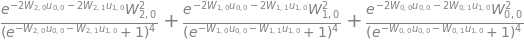

In [23]:
mt[0,0]

Metric tensor from sympy's Jacbians

In [24]:
sG = np.r_[[sy_eval(mt[alpha, beta], W, u, nW=tW.numpy(), nu=tu.numpy()) for alpha, beta in itertools.product(range(dim_u), range(dim_u))]].reshape(dim_u,dim_u)
sG

array([[ 0.12619385, -0.05193324],
       [-0.05193324,  0.03600009]])

Metric tensor from tensorflow Jacobians

In [25]:
def get_metric_tensor(tW, tu, transformation):
    with tf.GradientTape(persistent=True) as t:
        tx, ts, ta = transformation(tW, tu)
    tJ = t.jacobian(tx, tu)[:,0,:,0]
    tG = tf.matmul(tf.transpose(tJ), tJ)

    return tG

In [26]:
tG = get_metric_tensor(tW, tu, transformation)
tG

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 0.12619385, -0.05193324],
       [-0.05193324,  0.03600009]])>

Metric tensor by directly applying $g_{\alpha\beta} = \sum_{k=0}^2 \dot{\text{a}}(s^k)^2 W^k_\alpha W^k_\beta$ in tensorflow

In [27]:
def get_metric_tensor_PERCEPTRON(tW, tu, transformation):
    with tf.GradientTape(persistent=True) as t:
        tx, ts, ta = transformation(tW, tu)

    mG = np.r_[[[tf.reduce_sum(t.gradient(tx, ts)**2 * tW[:,alpha:alpha+1] * tW[:,beta:beta+1]).numpy() for alpha in range(dim_u)] for beta in range(dim_u)]]

    return mG

In [28]:
mG = get_metric_tensor_PERCEPTRON(tW, tu, transformation)
mG

array([[ 0.12619385, -0.05193324],
       [-0.05193324,  0.03600009]])

In [29]:
np.allclose(sG, tG.numpy()), np.allclose(tG.numpy(), mG)

(True, True)

### the inverse metric tensor

In [30]:
tG_ = tf.linalg.pinv(tG)
tG_

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[19.50242854, 28.13393853],
       [28.13393853, 68.36334741]])>

check they are inverses from each other

In [31]:
np.allclose(tG.numpy().dot(tG_.numpy()), np.eye(tG_.shape[0]))

True

## the Hessian

$$H^i_{\alpha \beta} = \frac{\partial x^i}{\partial u^\alpha \partial u^\beta} = \frac{\partial}{\partial u^\alpha}J^i_\beta$$

In this case:

$$\begin{align*}
\frac{\partial x^i}{\partial u^\alpha \partial u^\beta} =& \frac{\partial }{\partial u^\alpha}\Big[\dot{\text{a}}(s^i) W^i_\beta\Big] \\
 =& \frac{\partial }{\partial u^\alpha}\Big[\dot{\text{a}}(s^i)\Big] W^i_\beta + \dot{\text{a}}(s^i)\frac{\partial }{\partial u^\alpha}\Big[W^i_\beta\Big]\\
 =&\frac{\partial\dot{\text{a}}(s^i) }{\partial s^i}\frac{\partial s^i}{\partial u_\alpha} W^i_\beta\\
 =&\ddot{\text{a}}(s^i) W^i_\alpha W^i_\beta 
\end{align*}$$


In [32]:
H = sy.Matrix([[[J[i ,alpha].diff(u[beta,0]) for alpha in range(dim_u)] for beta in range(dim_u)] for i in range(dim_x)])
H

⎡⎡    -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    2       -2⋅W₀₀⋅u₀₀ - 2⋅W₀₁⋅u₁₀    2     -W₀₀⋅u₀₀ -
⎢⎢   ℯ                  ⋅W₀₀     2⋅ℯ                      ⋅W₀₀     ℯ          
⎢⎢- ────────────────────────── + ──────────────────────────────, - ───────────
⎢⎢                           2                              3                 
⎢⎢  ⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞      ⎛ -W₀₀⋅u₀₀ - W₀₁⋅u₁₀    ⎞        ⎛ -W₀₀⋅u₀₀
⎢⎣  ⎝ℯ                   + 1⎠      ⎝ℯ                   + 1⎠        ⎝ℯ        
⎢                                                                             
⎢⎡    -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    2       -2⋅W₁₀⋅u₀₀ - 2⋅W₁₁⋅u₁₀    2     -W₁₀⋅u₀₀ -
⎢⎢   ℯ                  ⋅W₁₀     2⋅ℯ                      ⋅W₁₀     ℯ          
⎢⎢- ────────────────────────── + ──────────────────────────────, - ───────────
⎢⎢                           2                              3                 
⎢⎢  ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞      ⎛ -W₁₀⋅u₀₀ - W₁₁⋅u₁₀    ⎞        ⎛ -W₁₀⋅u₀₀
⎢⎣  ⎝ℯ                   + 1⎠      ⎝ℯ               

In [33]:
sH= np.r_[[[[sy_eval(H[i,alpha][beta], W, u, nW=tW.numpy(), nu=tu.numpy())[0] for i in range(dim_x)] for alpha in range(dim_u)] for beta in range(dim_u)]].astype(float).T
sH

array([[[ 0.03468516,  0.00569407],
        [ 0.00569407,  0.00093476]],

       [[ 0.10130854, -0.04189015],
        [-0.04189015,  0.01732119]],

       [[-0.34631993,  0.25240458],
        [ 0.25240458, -0.18395728]]])

now in tensorflow

In [34]:
@tf.function
def get_hessian(tW, tu, transformation):
    with tf.GradientTape(persistent=True) as t1:
        with tf.GradientTape(persistent=True) as t2:
            tx, ts, ta = transformation(tW, tu)
        _tJ = t2.jacobian(tx, tu)[:,0,:,0]
    tH = t1.jacobian(_tJ, tu)[:,:,:,0]
    return tH

In [35]:
tH = get_hessian(tW, tu, transformation)
tH

<tf.Tensor: shape=(3, 2, 2), dtype=float64, numpy=
array([[[ 0.03468516,  0.00569407],
        [ 0.00569407,  0.00093476]],

       [[ 0.10130854, -0.04189015],
        [-0.04189015,  0.01732119]],

       [[-0.34631993,  0.25240458],
        [ 0.25240458, -0.18395728]]])>

In [36]:
np.allclose (tH.numpy(), sH)

True

### the christoffel symbols


$$\Gamma^\beta_{\mu\nu} = \frac{1}{2}g^{\beta\alpha}\Bigg(\frac{\partial g_{\alpha\mu}}{\partial u^\nu} + \frac{\partial g_{\alpha\nu}}{\partial u^\mu} - \frac{\partial g_{\mu\nu}}{\partial u^\alpha}  \Bigg)$$



$$\begin{align}
\text{The Metric Tensor}\;\;\;: \;\;\;&g_{\alpha\beta} &= \;\;\;& \sum_{k=0}^2 \dot{\text{a}}(s^k)^2 W^k_\alpha W^k_\beta
\end{align}$$



$$\frac{\partial g_{\alpha\beta}}{\partial u^\gamma} =  \sum_{k=0}^2 2\dot{\text{a}}(s^k)\ddot{\text{a}}(s^k) W^k_\alpha W^k_\beta W^k_\gamma$$

In [37]:
ts

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-0.5759448 ],
       [-0.94727428],
       [ 1.92824448]])>

In [38]:
# del(get_christoffel_symbols_v1)
# del(get_christoffel_symbols_v2)
#            tx, ts, ta = transformation(tW, tu)

i,j,k = tf.Variable(-1), tf.Variable(-1), tf.Variable(-1)

@tf.function
def get_christoffel_symbol(tg_, tdg_du, i, j ,k):
    return 0.5*tf.reduce_sum([tg_[i,a]*(tdg_du[k,a,j] + tdg_du[j,a,k] - tdg_du[k,j,a]) for a in range(tg_.shape[0])])    

@tf.function
def get_christoffel_symbols(tW, tu, transformation):   
    # using TF's full symbolic engine 
    with tf.GradientTape(persistent=True) as gtape2:
        with tf.GradientTape(persistent=True) as gtape1:
            tx, _, _ = transformation(tW, tu)

        tJ = gtape1.jacobian(tx, tu)[:,0,:,0]

        tg = tf.matmul(tf.transpose(tJ), tJ)
        tg_ = tf.linalg.inv(tg)   
        
    # let TF compute the derivatives of the metric tensor wrt source variables
    tdg_du = gtape2.jacobian(tg, tu)[:,:,:,0]

    r = []
    for vi,vj,vk in itertools.product(*[list(range(u.shape[0]))]*3):
        i.assign(vi)
        j.assign(vj)
        k.assign(vk)
        r.append(get_christoffel_symbol(tg_, tdg_du, i, j, k))
    
    return tf.reshape(r, [tu.shape[0]]*3)

@tf.function
def get_christoffel_symbols_PERCEPTRON(tW, tu, transformation):   
    # using the perceptron expressions for the derivative of the metric tensor
    # which just require the first and second derivatives of the activation function
    with tf.GradientTape(persistent=True) as gtape2:

        with tf.GradientTape(persistent=True) as gtape1:
            tx, ts, ta = transformation(tW, tu)

        tJ = gtape1.jacobian(tx, tu)[:,0,:,0]
        tg = tf.matmul(tf.transpose(tJ), tJ)
        tg_ = tf.linalg.inv(tg)   
        tdx_ds = gtape1.gradient(tx, ts)
        
    
    tdx_dsds = gtape2.jacobian(tdx_ds, ts)[:,0,:,0]
    tdx_dsds = tf.linalg.diag_part(tdx_dsds)

    # compute manually the derivatives of the metric tensor wrt source variables
    tdg_du = tf.reshape(
        tf.stack([tf.reduce_sum((tW[:,alpha:alpha+1] * tW[:,beta:beta+1] * tW[:,gamma:gamma+1])[:,0]*2*tdx_ds[:,0]*tdx_dsds) \
                   for alpha, beta, gamma in itertools.product(*[list(range(dim_u))]*3)]),
        (dim_u, dim_u, dim_u))    

    r = []
    for vi,vj,vk in itertools.product(*[list(range(u.shape[0]))]*3):
        i.assign(vi)
        j.assign(vj)
        k.assign(vk)
        r.append(get_christoffel_symbol(tg_, tdg_du, i, j, k))
    
    return tf.reshape(r, [tu.shape[0]]*3)

In [39]:
%%timeit -n 1 -r 1
tcf2 = get_christoffel_symbols(tW, tu, transformation)
print(tcf2.numpy())

[[[ 0.23398133  0.0096741 ]
  [ 0.0096741  -0.00869439]]

 [[-1.47620478  1.28079288]
  [ 1.28079288 -0.89929744]]]
867 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [40]:
%%timeit -n 1 -r 1
tcf1 = get_christoffel_symbols_PERCEPTRON(tW, tu, transformation)
print(tcf1.numpy())

[[[ 0.23398133  0.0096741 ]
  [ 0.0096741  -0.00869439]]

 [[-1.47620478  1.28079288]
  [ 1.28079288 -0.89929744]]]
824 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [41]:
np.allclose(get_christoffel_symbols_PERCEPTRON(tW, tu, transformation), get_christoffel_symbols(tW, tu, transformation))

True

# Summary

In [42]:
def transformation(tW, tu):
    tlinear = lambda x: x
    ta = lambda x: 1/(1+tf.exp(-x))
    ts = tf.matmul(tW,tu) + tb
    tx = ta(ts)
    return tx, ts, ta


In [43]:
tW = tf.Variable(np.random.normal(size=(dim_x,dim_u)))
tu = tf.Variable(np.random.normal(size=(dim_u,1)))
tb  = tf.Variable(np.zeros((dim_x,1)))
tW, tu

(<tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
 array([[-1.15159902, -2.99051546],
        [-0.38944001,  0.34125733],
        [-1.39846121, -0.18306849]])>,
 <tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
 array([[-0.61250047],
        [ 0.75652911]])>)

### check with `sympy` on a  2D manifold embedded in 3D ambient space

In [55]:
def transformation_sphere(tW, tu):
    tx = tf.stack([tf.sin(tu[0])*tf.cos(tu[1]), 
                   tf.sin(tu[0])*tf.sin(tu[1]), 
                   tf.cos(tu[0])])
    return tx, None, None

In [56]:
tu = tf.Variable(np.array([[-0.64853741], [ 0.45577495]]))

In [57]:
r, t, p = sy.symbols('r theta phi')

x, y, z = sy.symbols('x y z')
# define the metric 
metric = [[0 for i in range(3)] for i in range(3)]
metric[0][0] = 1
metric[1][1] = 1
metric[2][2] = 1
# creating metric object of 3D ambient space
mh = MetricTensor(metric, (x, y, z))

# ------------------
# the transformation
# ------------------
xf = sy.sin(t)*sy.cos(p)
yf = sy.sin(t)*sy.sin(p)
zf = sy.cos(t)

esyms = [t, p]
hfuncs = [xf, yf, zf]

me = [[0,0],[0,0]]
for ki,kj in itertools.product(*([range(len(esyms))]*len(esyms))):
    me[ki][kj] = (sum([hfuncs[m].diff(esyms[ki])*hfuncs[n].diff(esyms[kj])*mh[m,n] \
                for m,n in itertools.product(*([range(len(hfuncs))]*len(esyms)))])).simplify()
me = MetricTensor(me, (t,p))
cf = ChristoffelSymbols.from_metric(me)

In [58]:
sme = me.tensor().subs({t: tu.numpy()[0,0], p: tu.numpy()[1,0]})
sme = np.r_[[sme[i,j] for i,j in itertools.product(range(dim_u), range(dim_u))]].reshape(dim_u, dim_u).astype(float)
sme

array([[1.        , 0.        ],
       [0.        , 0.36484187]])

In [59]:
tme = get_metric_tensor(tW, tu, transformation_sphere).numpy()
tme

array([[1.        , 0.        ],
       [0.        , 0.36484187]])

In [60]:
scf = cf.tensor().subs({t: tu.numpy()[0,0], p: tu.numpy()[1,0]})
scf = np.r_[[scf[i,j,k] for i,j,k in itertools.product(range(dim_u), range(dim_u), range(dim_u))]].reshape(dim_u, dim_u, dim_u).astype(float)
scf

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.48138579]],

       [[ 0.        , -1.31943681],
        [-1.31943681,  0.        ]]])

In [61]:
mcf = get_christoffel_symbols(tW, tu, transformation_sphere).numpy()
mcf

array([[[-5.55111512e-17,  5.55111512e-17],
        [ 5.55111512e-17,  4.81385791e-01]],

       [[-7.60756315e-17, -1.31943681e+00],
        [-1.31943681e+00,  0.00000000e+00]]])

check on many random points

In [62]:
from progressbar import progressbar as pbar
from time import time
ttimes = []
stimes = []
for _ in pbar(range(200)):
    tu = tf.Variable(np.random.normal(size=(dim_u,1)))
    s_start = time()
    sme = me.tensor().subs({t: tu.numpy()[0,0], p: tu.numpy()[1,0]})
    sme = np.r_[[sme[i,j] for i,j in itertools.product(range(dim_u), range(dim_u))]].reshape(dim_u, dim_u).astype(float)
    scf = cf.tensor().subs({t: tu.numpy()[0,0], p: tu.numpy()[1,0]})
    scf = np.r_[[scf[i,j,k] for i,j,k in itertools.product(range(dim_u), range(dim_u), range(dim_u))]].reshape(dim_u, dim_u, dim_u).astype(float)
    s_elapsed = time()-s_start
    
    t_start = time()
    tme = get_metric_tensor(tW, tu, transformation_sphere).numpy()
    tcf = get_christoffel_symbols(tW, tu, transformation_sphere).numpy()
    t_elapsed = time() - t_start

    stimes.append(s_elapsed)
    ttimes.append(t_elapsed)
    
    assert np.allclose(sme, tme)
    assert np.allclose(scf, tcf)

100% (200 of 200) |######################| Elapsed Time: 0:00:38 Time:  0:00:38


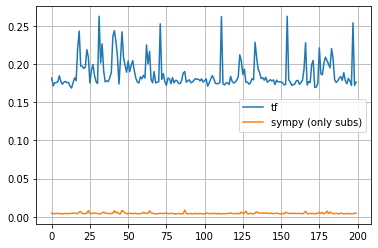

In [63]:
plt.plot(ttimes, label="tf")
plt.plot(stimes, label="sympy (only subs)")
plt.legend(); plt.grid();